## import packages

In [1]:
import pandas
pandas.set_option("display.max_rows", 50, "display.max_columns", 50)

import numpy
import pygsheets

import matplotlib.pyplot as mp
import matplotlib

import geopandas
import cartopy
import shapely

In [2]:
import dash

## import nat earth data shapefile

In [4]:
#nat_earth_gdf = geopandas.read_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/'
#                                        +'ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp')
nat_earth_gdf = geopandas.read_file('/Users/baird/Dropbox/_gis-data/_natural_earth_data/'
                                        +'ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')
#nat_earth_gdf = geopandas.read_file('/Users/baird/Dropbox/_shapefiles/_natural_earth_data/'
#                                        +'ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

In [5]:
nat_earth_gdf.loc[nat_earth_gdf.ADMIN=='Czechia', 'ADMIN'] = 'Czech Republic'

## import pipelines

In [6]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1MX_6I2QW07lFFWMO-k3mjthBlQGFlv5aTMBmvbliYUY') # Mar 22 2022 version for EGT report

gas_pipes = spreadsheet.worksheet('title', 'Gas pipelines').get_as_df()
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df()
#owners = spreadsheet[2].get_as_df()

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)
pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
# remove empty cells for pipes, owners
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

#get other relevant sheets
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [7]:
# special cases
# as of Feb 22, Nord Stream 2 is "Idle" in our data but should probably be "Construction"...

# force Nigeria-Morocco Pipeline to be Proposed (instead of Construction)
country_ratios_df.loc[country_ratios_df.PipelineName=='Nord Stream 2', 'Status'] = 'Construction'
pipes_df_orig.loc[pipes_df_orig.PipelineName=='Nord Stream 2', 'Status'] = 'Construction'

In [8]:
country_ratios_df.replace('--', numpy.nan, inplace=True)
pipes_df_orig.replace('--', numpy.nan, inplace=True)

In [9]:
# https://www.gem.wiki/Poland-Ukraine_Interconnector_Gas_Pipeline
# our country_ratios code calculates this is half in each country, but it's not
country_ratios_df.loc[(country_ratios_df.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df.Country=='Poland'),'LengthKnownKmByCountry'] = 1.5

country_ratios_df.loc[(country_ratios_df.PipelineName=='Poland-Ukraine Interconnector Gas Pipeline')&
                      (country_ratios_df.Country=='Ukraine'),'LengthKnownKmByCountry'] = 99.0

### convert routes to geometry objects

In [10]:
def convert_gfit_to_linestring(coord_str, pipeline_name):
    '''
    Takes string from GFIT column of coordinates for a single pipeline,
    converts that string into Shapely LineString or MultiLinestring.
    '''
    #print(coord_str, pipeline_name)
    if ':' in coord_str and ';' not in coord_str:
        # simple geometry; no branching
        # create nested list of lists, separating on colons        
        coord_list = coord_str.split(':')
        coord_list_tuples = []
        # non-branched pipeline (nested list with one level)
        # convert nested list of lists to list of tuples
        try:
            for element in coord_list:
                element_tuple = (float(element.split(',')[1]), 
                                 float(element.split(',')[0]))
                coord_list_tuples.append(element_tuple)
        except:
            print(f"Exception for {pipeline_name}; element: {element}") # for db
        route_conv = shapely.geometry.LineString(coord_list_tuples)

    elif ':' in coord_str and ';' in coord_str:
        # create a nested list of lists, separating on semicolons
        coord_list = coord_str.split(';')   
        # create a second level of nesting, separating on colons
        coord_list = [x.split(':') for x in coord_list]
        # branched pipeline (nested list with two levels)
        route_conv_list_all = []
        
        for nested_list in coord_list:
            coord_list_tuples = []
            # process element
            try:
                for element in nested_list:
                    element_tuple = (float(element.split(',')[1]), 
                                     float(element.split(',')[0]))
                    coord_list_tuples.append(element_tuple)
            except:
                print(f"Exception for {pipeline_name}; element: {element}") # for db
            # process coord_list_tuples
            try:
                route_conv_list = shapely.geometry.LineString(coord_list_tuples)
                route_conv_list_all.append(route_conv_list)
            except:
                print(f"Exception for {pipeline_name}; coord_list_tuples: {coord_list_tuples}") # for db
                pass
            
        route_conv = shapely.geometry.MultiLineString(route_conv_list_all)
        
    return route_conv

In [11]:
def convert_all_pipelines(df):
    """
    Apply the conversion function to all pipelines in the dataframe.
    """
    # create geometry column with empty strings
    #df.assign(ColName='geometry', dtype='str')
    df['geometry'] = ''
    #print(df['geometry'])
    
    # filter to keep only pipelines with routes
    mask_route = df['Route'].str.contains(',' or ':')
    pipes_with_route = df.loc[mask_route]
    
    for row in pipes_with_route.index:
        route_str = df.at[row, 'Route']
        pipeline_name = df.at[row, 'PipelineName']
        
        route_str_converted = convert_gfit_to_linestring(route_str, pipeline_name)
    
        #print(df.at[row,'ProjectID'])
        #print(pipeline_name)
        #print(route_str_converted)
        
        df.at[row, 'geometry'] = route_str_converted   
        
    return df

In [12]:
# code to create a dataframe with WKT formatted geometry
no_route_options = [
    'Unavailable', 
    'Capacity expansion only', 
    'Bidirectionality upgrade only',
    'Short route (< 100 km)', 
    'N/A',
    ''
]

# (1) copy, clean up
to_convert_df = pipes_df_orig.copy()
to_convert_df = to_convert_df[~to_convert_df['Route'].isin(no_route_options)]

# also keep the non-converted ones separate
not_converted_df = pipes_df_orig.copy()
not_converted_df = not_converted_df[not_converted_df['Route'].isin(no_route_options)]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.MultiLineString()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all pipelines
pipes_df_wkt = convert_all_pipelines(to_convert_df)
pipes_df_wkt = pipes_df_wkt.reset_index(drop=True)

# (3) store in a GeoDataFrame, attach a projection, transform to a different one
pipes_df_wkt_gdf = geopandas.GeoDataFrame(pipes_df_wkt, geometry=pipes_df_wkt['geometry'])
pipes_df_wkt_gdf = pipes_df_wkt_gdf.set_crs('epsg:4326')
pipes_df_wkt_gdf_4087 = pipes_df_wkt_gdf.to_crs('epsg:4087')

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  result[:] = values


Exception for Trans-Adriatic Gas Pipeline; coord_list_tuples: [(18.38, 40.265)]


In [13]:
pipes_df_converted_routes = pandas.concat([pipes_df_wkt_gdf, not_converted_gdf])
pipes_df_converted_routes = pipes_df_converted_routes.reset_index(drop=True)
pipes_df_converted_routes.sort_values('ProjectID', inplace=True)

In [14]:
pipes_gdf = geopandas.GeoDataFrame(pipes_df_converted_routes, geometry=pipes_df_converted_routes['geometry'])

## import terminals

In [15]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
spreadsheet = gc.open_by_key('1nQChDxZXBaHX53alSXfD0IHpHdxpUSjMALEaR_JNFXE') # mar 22 2022 version for EGT report

#spreadsheet[1] "Gas Pipelines" tab is the second index
#terms_df_orig = spreadsheet[1].get_as_df(encoding='latin1')

terms_df_orig = spreadsheet.worksheet('title', 'Terminals').get_as_df()

In [16]:
# replace all -- with nans
terms_df_orig.replace('--', numpy.nan, inplace=True)
# remove oil export terminals
terms_df_orig = terms_df_orig.loc[terms_df_orig['Type1']!='Oil']
# remove anything without a wiki page
terms_df_orig = terms_df_orig.loc[terms_df_orig['Wiki']!='']

In [17]:
region_df_orig = spreadsheet.worksheet('title', 'Region dictionary').get_as_df()

In [18]:
region_df_eu = region_df_orig.copy()[region_df_orig['EuropeanUnion']=='Yes']
region_df_egt = region_df_orig.copy()[region_df_orig['EuroGasTracker']=='Yes']
region_df_europe = region_df_orig.copy()[region_df_orig['Region']=='Europe']
region_df_touse = region_df_eu.copy()

country_list = region_df_touse.Country

### get iso codes

### convert terminal lat/lon to geometry objects

In [19]:
# code to create a dataframe with WKT formatted geometry
no_lonlat_options = [
    'Unknown',
    'TBD'
]

# (1) copy, clean up
to_convert_df = terms_df_orig.copy()
to_convert_df = to_convert_df[~(to_convert_df['Latitude'].isin(no_lonlat_options)) |
                             ~(to_convert_df['Longitude'].isin(no_lonlat_options))]

# also keep the non-converted ones separate
not_converted_df = terms_df_orig.copy()
not_converted_df = not_converted_df[(not_converted_df['Longitude'].isin(no_lonlat_options)) | 
                                    (not_converted_df['Latitude'].isin(no_lonlat_options))]
# add a dummy column so that the dimensions match with converted wkt pipelines
not_converted_df.assign(ColName='geometry')
not_converted_df['geometry'] = [shapely.geometry.Point()]*not_converted_df.shape[0]
not_converted_df.reset_index(drop=True)
not_converted_gdf = geopandas.GeoDataFrame(not_converted_df, geometry=not_converted_df['geometry'])

# (2) convert all terminals
terms_df_converted = to_convert_df.copy()
terms_df_converted.assign(ColName='geometry')
terms_df_converted['geometry'] = to_convert_df[['Longitude','Latitude']].apply(shapely.geometry.Point, axis=1)
terms_df_converted = terms_df_converted.reset_index(drop=True)

# # (3) store in a GeoDataFrame, attach a projection, transform to a different one
terms_df_gdf = geopandas.GeoDataFrame(terms_df_converted, geometry=terms_df_converted['geometry'])
terms_df_gdf = terms_df_gdf.set_crs('epsg:4326')
terms_df_gdf_4087 = terms_df_gdf.to_crs('epsg:4087')

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:118: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In [20]:
terms_df_converted_locations = pandas.concat([terms_df_gdf, not_converted_gdf])
terms_df_converted_locations = terms_df_converted_locations.reset_index(drop=True)
terms_df_converted_locations.sort_values('ComboID', inplace=True)

In [21]:
terms_gdf = geopandas.GeoDataFrame(terms_df_converted_locations, geometry=terms_df_converted_locations['geometry'])
terms_gdf_region = terms_gdf.loc[terms_gdf['Country'].isin(region_df_touse.Country)]

## colors

## proposed LNG terminal capacities, broken down by Construction and Pre-construction

In [22]:
terms_df_capacity_sum = pandas.DataFrame(0, index=country_list, columns=['Proposed','Construction'])
terms_df_region = terms_df_orig[(terms_df_orig.Country.isin(region_df_touse.Country))&
                                (terms_df_orig.Status.isin(['Construction','Proposed']))&
                                (terms_df_orig.Facility.isin(['Import']))]

# proposed
terms_df_capacity_sum['Proposed'] += terms_df_region.loc[terms_df_region.Status=='Proposed'].groupby(
    'Country')['CapacityInBcm/y'].sum()
# construction
terms_df_capacity_sum['Construction'] += terms_df_region.loc[terms_df_region.Status=='Construction'].groupby(
    'Country')['CapacityInBcm/y'].sum()

terms_df_capacity_sum.replace(numpy.nan,0,inplace=True)

# reorder for descending values
country_order = terms_df_capacity_sum.sum(axis=1).sort_values(ascending=True).index
terms_df_capacity_sum = terms_df_capacity_sum.reindex(country_order)

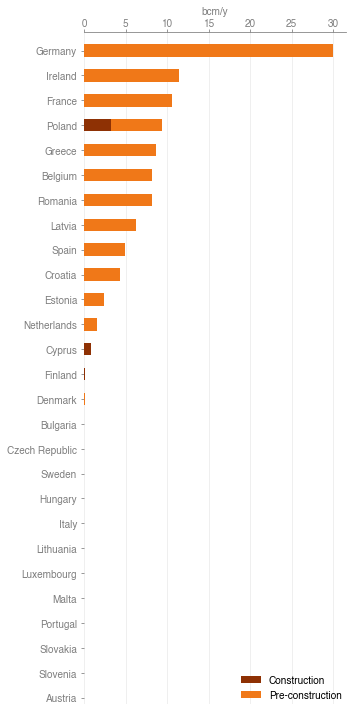

In [23]:
cmap_to_sample = matplotlib.cm.get_cmap('YlOrBr')
bar_dark = cmap_to_sample(0.9)
bar_light = cmap_to_sample(0.6)

font_size = 10
axis_color='0.5'

fig = mp.figure(figsize=(5,10))

ax = fig.add_subplot(111)

nbars = terms_df_capacity_sum.index.size

# construction
ax.barh(numpy.arange(nbars), 
        terms_df_capacity_sum['Construction'], 
        facecolor=bar_dark, 
        label='Construction', height=0.5)

# proposed
ax.barh(numpy.arange(nbars),
        terms_df_capacity_sum['Proposed'], 
        left=terms_df_capacity_sum['Construction'],
        facecolor=bar_light, 
        label='Pre-construction', height=0.5)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(terms_df_capacity_sum.index)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
#ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,26.75)
ax.set_xlabel('bcm/y', size=font_size, color=axis_color)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right', borderaxespad=0)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['top'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.tick_params(colors=axis_color)

ax.xaxis.grid([2,4,6,8], alpha=0.25)
ax.set_axisbelow(True)

fig.tight_layout()
#fig.savefig('Euro-Gas-dashboard-LNGterm-capacity-bargraph.png', bbox_inches='tight', transparent=True)

### add map version

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:
/Users/baird/miniconda3/envs/gem/lib/python

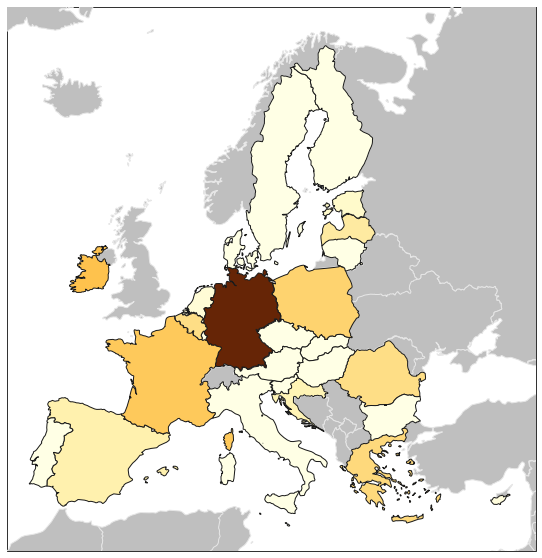

In [24]:
# add column with normalized values
terms_df_capacity_sum['Normalized'] = terms_df_capacity_sum[
    ['Proposed','Construction']].sum(axis=1)/terms_df_capacity_sum[
    ['Proposed','Construction']].sum(axis=1).max()

cmap_to_sample = matplotlib.cm.get_cmap('YlOrBr')

# colors for countries
terms_df_capacity_sum['NormalizedColor'] = list(tuple(map(tuple,cmap_to_sample(terms_df_capacity_sum.Normalized))))

operating_color = '0.5'
prop_color = bar_light
const_color = bar_dark

map_proj = cartopy.crs.LambertConformal(central_longitude=10, central_latitude=52, standard_parallels=(35,65))
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=map_proj)

for idx,row in nat_earth_gdf.iterrows():
    if row.ADMIN in terms_df_capacity_sum.index:
        
        normalized_color = terms_df_capacity_sum.loc[row.ADMIN,'NormalizedColor']
        ax.add_geometries([row.geometry], crs=data_proj,
                          facecolor=normalized_color, edgecolor='0.1', zorder=10)
    else:
        ax.add_geometries([row.geometry], crs=data_proj,
                          facecolor='0.75', edgecolor='0.9', zorder=9)

ax.set_extent([-10,36,34,72], crs=cartopy.crs.PlateCarree())
#fig.savefig('Euro-Gas-dashboard-LNGterm-capacity-map.png', bbox_inches='tight', transparent=False)

## km length in countries

In [25]:
country_ratios_df_region = country_ratios_df[(country_ratios_df.Country.isin(region_df_touse.Country))&
                                (country_ratios_df.Status.isin(['Construction','Proposed']))]

In [26]:
pipes_df_length_sum = pandas.DataFrame(0, index=country_list, columns=['Proposed','Construction'])

# proposed
pipes_df_length_sum['Proposed'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Proposed'].groupby(
    'Country')['MergedKmByCountry'].sum()
# construction
pipes_df_length_sum['Construction'] += country_ratios_df_region.loc[country_ratios_df_region.Status=='Construction'].groupby(
    'Country')['MergedKmByCountry'].sum()

pipes_df_length_sum.replace(numpy.nan,0,inplace=True)

# reorder for descending values
country_order = pipes_df_length_sum.sum(axis=1).sort_values(ascending=True).index
pipes_df_length_sum = pipes_df_length_sum.reindex(country_order)

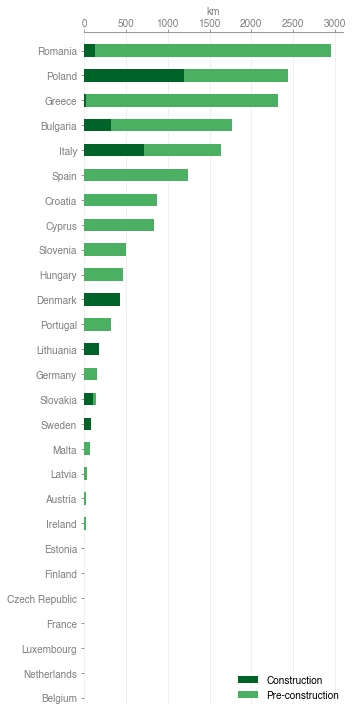

In [27]:
cmap_to_sample = matplotlib.cm.get_cmap('Greens')
bar_dark = cmap_to_sample(0.9)
bar_light = cmap_to_sample(0.6)

font_size = 10
axis_color='0.5'

fig = mp.figure(figsize=(5,10))

ax = fig.add_subplot(111)

nbars = terms_df_capacity_sum.index.size

# construction
ax.barh(numpy.arange(nbars), 
        pipes_df_length_sum['Construction'], 
        facecolor=bar_dark, 
        label='Construction', height=0.5)

# proposed
ax.barh(numpy.arange(nbars),
        pipes_df_length_sum['Proposed'], 
        left=pipes_df_length_sum['Construction'],
        facecolor=bar_light, 
        label='Pre-construction', height=0.5)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(pipes_df_length_sum.index)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
#ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,26.75)
ax.set_xlabel('km', size=font_size, color=axis_color)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right', borderaxespad=0)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['top'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.tick_params(colors=axis_color)

ax.xaxis.grid([2,4,6,8], alpha=0.25)
ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig('Euro-Gas-dashboard-pipeline-km-bargraph.png', bbox_inches='tight', transparent=True)

### add map version

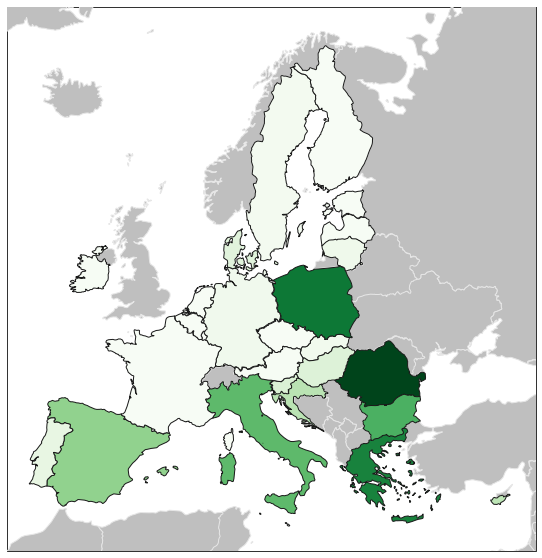

In [28]:
# add column with normalized values
pipes_df_length_sum['Normalized'] = pipes_df_length_sum[
    ['Proposed','Construction']].sum(axis=1)/pipes_df_length_sum[
    ['Proposed','Construction']].sum(axis=1).max()

cmap_to_sample = matplotlib.cm.get_cmap('Greens')

# colors for countries
pipes_df_length_sum['NormalizedColor'] = list(tuple(map(tuple,cmap_to_sample(pipes_df_length_sum.Normalized))))

operating_color = '0.5'
prop_color = bar_light
const_color = bar_dark

map_proj = cartopy.crs.LambertConformal(central_longitude=10, central_latitude=52, standard_parallels=(35,65))
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=map_proj)

for idx,row in nat_earth_gdf.iterrows():
    if row.ADMIN in pipes_df_length_sum.index:
        
        normalized_color = pipes_df_length_sum.loc[row.ADMIN,'NormalizedColor']
        ax.add_geometries([row.geometry], crs=data_proj,
                          facecolor=normalized_color, edgecolor='0.1', zorder=10)
    else:
        ax.add_geometries([row.geometry], crs=data_proj,
                          facecolor='0.75', edgecolor='0.9', zorder=9)

ax.set_extent([-10,36,34,72], crs=cartopy.crs.PlateCarree())
fig.savefig('Euro-Gas-dashboard-pipeline-km-map.png', bbox_inches='tight', transparent=False)

## pre-FID or FID decisions

In [29]:
projects_df_fid_sum = pandas.DataFrame(0, index=country_list, columns=['PipelinesFID','TerminalsFID','PipelinesPreFID','TerminalsPreFID'])

# Pipelines
projects_df_fid_sum['PipelinesFID'] += country_ratios_df_region[country_ratios_df_region.FID.isin(['FID'])].groupby('Country')['LengthPerCountryFraction'].sum()
projects_df_fid_sum['PipelinesPreFID'] += country_ratios_df_region[country_ratios_df_region.FID.isin(['Pre-FID'])].groupby('Country')['LengthPerCountryFraction'].sum()
# Terminals
projects_df_fid_sum['TerminalsFID'] += terms_df_region.loc[terms_df_region.FID.isin(['FID'])].groupby('Country')['TerminalID'].count()
projects_df_fid_sum['TerminalsPreFID'] += terms_df_region.loc[terms_df_region.FID.isin(['Pre-FID'])].groupby('Country')['TerminalID'].count()

projects_df_fid_sum.replace(numpy.nan,0,inplace=True)

# reorder for descending values
country_order = projects_df_fid_sum.sum(axis=1).sort_values(ascending=True).index
projects_df_fid_sum = projects_df_fid_sum.reindex(country_order)

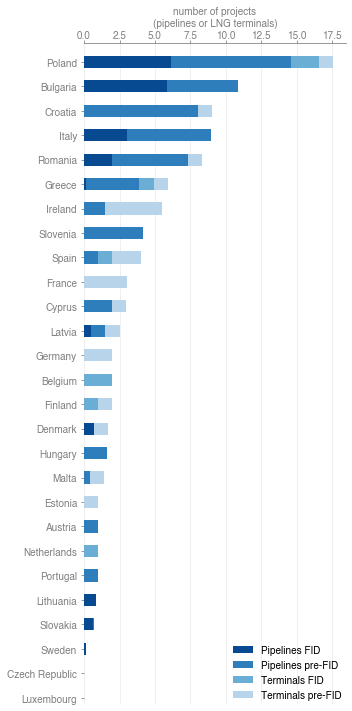

In [30]:
cmap_to_sample = matplotlib.cm.get_cmap('Blues')
bar_pipes_dark = cmap_to_sample(0.9)
bar_pipes_light = cmap_to_sample(0.7)
bar_terms_dark = cmap_to_sample(0.5)
bar_terms_light = cmap_to_sample(0.3)

font_size = 10
axis_color='0.5'

fig = mp.figure(figsize=(5,10))

ax = fig.add_subplot(111)

nbars = terms_df_capacity_sum.index.size

# pipelines
ax.barh(numpy.arange(nbars), 
        projects_df_fid_sum['PipelinesFID'], 
        facecolor=bar_pipes_dark, 
        label='Pipelines FID', height=0.5)
ax.barh(numpy.arange(nbars),
        projects_df_fid_sum['PipelinesPreFID'], 
        left=projects_df_fid_sum['PipelinesFID'],
        facecolor=bar_pipes_light, 
        label='Pipelines pre-FID', height=0.5)

ax.barh(numpy.arange(nbars), 
        projects_df_fid_sum['TerminalsFID'],
        left=projects_df_fid_sum[['PipelinesFID','PipelinesPreFID']].sum(axis=1),
        facecolor=bar_terms_dark, 
        label='Terminals FID', height=0.5)
ax.barh(numpy.arange(nbars),
        projects_df_fid_sum['TerminalsPreFID'], 
        left=projects_df_fid_sum[['PipelinesFID','PipelinesPreFID','TerminalsFID']].sum(axis=1),
        facecolor=bar_terms_light, 
        label='Terminals pre-FID', height=0.5)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(projects_df_fid_sum.index)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
#ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,26.75)
ax.set_xlabel('number of projects\n(pipelines or LNG terminals)', size=font_size, color=axis_color)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right', borderaxespad=0)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.spines['top'].set_color(axis_color)
ax.spines['left'].set_color(axis_color)
ax.tick_params(colors=axis_color)

ax.xaxis.grid([2,4,6,8], alpha=0.25)
ax.set_axisbelow(True)

fig.tight_layout()
fig.savefig('Euro-Gas-dashboard-FID-bargraph.png', bbox_inches='tight', transparent=True)

## n pipelines/terminals across EU over time

## base map of countries

/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:825: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:877: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/Users/baird/miniconda3/envs/gem/lib/python3.9/site-packages/cartopy/crs.py:944: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


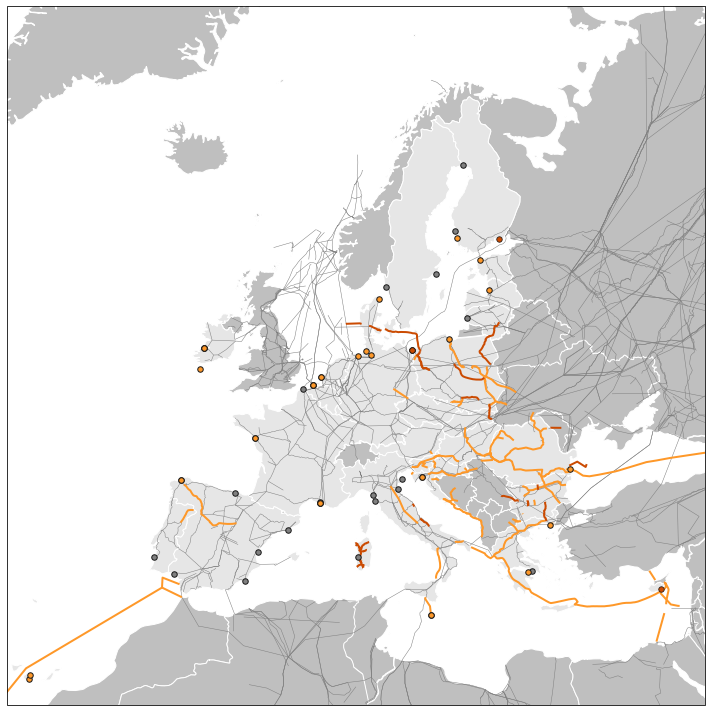

In [31]:
cmap_to_sample = matplotlib.cm.get_cmap('YlOrBr')
bar_dark = cmap_to_sample(0.75)
bar_light = cmap_to_sample(0.5)

operating_color = '0.5'
prop_color = bar_light
const_color = bar_dark

map_proj = cartopy.crs.LambertConformal(central_longitude=10, 
                                        central_latitude=52, 
                                        standard_parallels=(35,65))
data_proj = cartopy.crs.PlateCarree()

fig = mp.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection=map_proj)

for idx,row in nat_earth_gdf.iterrows():
    if row.ADMIN in region_df_touse.Country.tolist():
        ax.add_geometries([row['geometry']], crs=data_proj, facecolor='0.9', edgecolor='1', zorder=1)
    else:
        ax.add_geometries([row['geometry']], crs=data_proj, facecolor='0.75', edgecolor='1', zorder=0)

#ax.add_geometries(nat_earth_gdf['geometry'], crs=data_proj, facecolor='0.9', edgecolor='1')
#ax.add_geometries(nat_earth_gdf_region['geometry'], crs=data_proj, facecolor='0.75', edgecolor='1')

ax.set_extent([-18,35,30,75], crs=cartopy.crs.PlateCarree())

# operating
ax.add_geometries(pipes_gdf.loc[pipes_gdf.Status.isin(['Operating'])]['geometry'], 
                  crs=data_proj, edgecolor=operating_color, linewidth=0.5, facecolor='None')
# proposed
ax.add_geometries(pipes_gdf.loc[(pipes_gdf.Status.isin(['Proposed']))&
              ((pipes_gdf.StartCountry.isin(region_df_touse.Country))|
               pipes_gdf.EndCountry.isin(region_df_touse.Country))]['geometry'], 
                  crs=data_proj, edgecolor=prop_color, linewidth=2, facecolor='None')
# construction
ax.add_geometries(pipes_gdf.loc[(pipes_gdf.Status.isin(['Construction']))&
              ((pipes_gdf.StartCountry.isin(region_df_touse.Country))|
               pipes_gdf.EndCountry.isin(region_df_touse.Country))]['geometry'], 
                  crs=data_proj, edgecolor=const_color, linewidth=2, facecolor='None')

# regional terms
points = list(terms_gdf_region.loc[terms_gdf.Status.isin(['Operating'])]['geometry'])
ax.scatter([point.x for point in points],
           [point.y for point in points],
           transform=data_proj, zorder=2, s=30, facecolor=operating_color, edgecolor='0.1')

points = list(terms_gdf_region.loc[terms_gdf.Status.isin(['Proposed'])]['geometry'])
ax.scatter([point.x for point in points],
           [point.y for point in points],
           transform=data_proj, zorder=2, s=30, facecolor=prop_color, edgecolor='0.1')

points = list(terms_gdf_region.loc[terms_gdf.Status.isin(['Construction'])]['geometry'])
ax.scatter([point.x for point in points],
           [point.y for point in points],
           transform=data_proj, zorder=2, s=30, facecolor=const_color, edgecolor='0.1', linewidth=0.75)

fig.tight_layout()
fig.savefig('Euro-Gas-dashboard-map-50m-res.pdf', transparent=False, bbox_inches='tight')